# Flexible synthetic control 

We are going to compare three difference synthetic control models:
1. Doudchenko and Imbens (2013) , **DI**;
2. Constrained Lasso, **CL**; and
3. Abadie, Diamond, Hainmueller, **ADH**.

We are gonna code all these models up, and then compare their performance across different synthetic datasets. For now we are going to focus on the bias of their estimates, and then compare their inference, and then statistical power.


### Doudchenko and Imbens (DI)
Doudchenko and Imbens (2013) - [arxiv link](https://arxiv.org/abs/1610.07748) - hereafter **DI**. The main motivation is that difference-in-difference (DiD) and synthetic control (SC) methods can be generalized as their constraints around how to estimate weights $\omeega$ that can be used create the counterfactual outcome of the treatment as if it were control, 
$\hat{Y}_{0,T}(0) = \mu + \sum^N_{i=1} \omega_i Y_{i,T}$ , 


where $i=0$ denotes the treated unit; $i=1,...,N$ are control units, and $T$ is a given time period.

|Formula | Condition | Model that use this Condition |
|------|---| ---|
|$\mu=0$| (No-Intercept)| SC |
|$\sum_i^N \omega_i = 1$ | (Adding-Up)| DiD, SC |
|$\omega_i \geq 0$ | (Non-Negativity)| DiD, SC |
|$\omega_i = \bar{\omega_i}$ | (Constant-Weights)| DiD |

The (No-Intercept) and (Adding-Up) assumption works against us if our treated units ($i=0$) is an outlier unit compared to other control units ($i=1,...,N$). Note that DiD won't have this problem because it allows for an intercept difference. 

The (Non-Negativity) assumes can give us additional precision because only a few units can have weights, and allows good interpretability. However, allowing a more uniform distribution of weights and allowing them to be negative can reduce bias, as we can see in some matching scenarios [Abadie and Imbens, 2011](https://economics.mit.edu/files/11861). 

Finally, one of SC's contributions is relaxing the (Constant-Weights) assumption in DiD so have flexible weights.





**DI** proposes a way to estimate $(\mu, \omega)$ that allows us to relax all of the assumptions, using a penalized function. Note that $||...||_l$ is the $l$-th penalty function, where $l=1$ is absolute value and $l=2$ is squared.


$$ (\hat{\mu}(\lambda, \alpha), \hat{\omega}(\lambda, \alpha))  = \text{argmin} \Big\{ || Y_{0,t'} - \mu - \sum_{i=1}^N \omega_i Y_{i, t'} | t' < 0  + ||^2_2 + \lambda ( \frac{1-\alpha}{2}||\omega||^2_2 + \alpha||\omega||_1)   \Big\} $$

This would be estimated with an elastic net function. Note that:
1. We don't want to scale the control unit outcomes because since we have an intercept the interpretation won't be correct if we scale.
2. Weights are *only likely* to sum up to one, so we need to be careful about estimates that shrink $\omega$ towards zero. This is exactly what the original SC model deals with.
3. Imposing LASSO won't work because since the weights are likely to sum to one, just an L1-penalty would be useful.

The above two issues are addressed with a particular type of cross-validation. Where regular cross-validation would have us split the treated and control units randomly, we only want to evaluate on control units. 

1. Choose values of $\lambda, \alpha$.
2. Exclude treated unit $i=0$ from the sample.
3. For each control unit $j=1,...,N$:
    1. Pretend unit $j$ is the control unit.
    2. Estimate $\omega, \mu$ using the elastic net $-\rightarrow \omega_j, \mu_j$
    3. Calculate the predicted difference: $Y_j - \mu_j - \omega_j^T Y_{-j} \rightarrow \tilde{Y}_j$
4. Calculate a single statistics over the predicted differences, for example $MSE = \frac{1}{N}\sum_j ( \tilde{Y}_j)^2$

Repeat Steps 1 through 4 for different values of $\lambda, \alpha$. Pick $\lambda, \alpha$ with the best performance of MSE above. Note that $\alpha >0 $ and $0\leq \lambda \leq 1$

Our procedure for coding this up is to have separate functions that do:
1. Clean data to identify $Y_0$ and  $Y_i$ datasets.
2. Given $Y_0$ (or a pretend $Y_j$), $Y_i$, and $\lambda,\alpha$, estimate $\mu, \omega$.
3. Only use $Y_i$ to estimate $\lambda,\alpha$. - This can be done by a grid search, or through an optimizer if we like.

### Constrained Lasso (CL)

**Let's also try another type of SC**
Called the *Constrained Lasso* found in *Chernozhukov, Wuthrich, and Zhu*: https://arxiv.org/abs/1712.09089. Here, our function is still penalized but it is hyper-parameter free:

$$ (\hat{\mu}, \hat{\omega}) = \text{ argmin } \Big\{  Y_{0,t'} - \mu - \sum^N_{i=1} \omega_i Y_{i,t'} | t' < 0   + ||\omega_i||_1 \leq 1 \Big\}$$

Unlike **DI** we can get formal properities of this model, hereafter **CL.** 

### Abadie, Diamond, Hainmueller (ADH)
We refer to the Abadie, Diamond, Hainmueller (2010): https://economics.mit.edu/files/11859. Our function has additional constraints on it:
$$ (\hat{\omega}) = \text{ argmin } \Big\{  Y_{0,t'} - \sum^N_{i=1} \omega_i Y_{i,t'} | t' < 0   , \text{ s.t. } \sum^N_{i=1}\omega_i =1 , \omega_i \geq 0 \Big\}$$

Note that $\mu$ is no longer there.


**For inference:** we are going to use *conformal inference* (see the *Conformal Inference* notebook) following Chernozhukov, Wuthrich, and Zhu : https://arxiv.org/abs/1712.09089. 

In [23]:
import pandas as pd
import numpy as np
import os as os 

import matplotlib.pyplot as plt
%matplotlib inline  
from IPython.display import display    

import scipy.stats 
from sklearn.linear_model import ElasticNet
import statsmodels.api as sm

/Users/hsujulia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/hsujulia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [24]:

class di:
    def estimate_mu_omega(treatment_pre, control_pre, alpha_lambda_0):
        alpha_0, lambda_0 = alpha_lambda_0[0], alpha_lambda_0[1]
        elnet = ElasticNet(random_state=2736, alpha=alpha_0, l1_ratio=lambda_0)
        elnet.fit(control_pre, treatment_pre )
        ## Output interpretable weights
        try:
            df_weights = pd.DataFrame(index=elnet.feature_names_in_, 
                         data=elnet.coef_.T,
                        columns=treatment_pre.columns)
        except:
            df_weights = pd.DataFrame(index=elnet.feature_names_in_, 
                         data=elnet.coef_.T)        
        return {'mu': elnet.intercept_, 'omega': elnet.coef_, 'weights':df_weights, 'full':elnet}

    def predict_mu_omega(treatment_pre, control_pre, alpha_lambda_0, holdout_windows):
        ## Don't use all the control data
        ## Make sure that the holdout windows add up to the total number of pre-treatment units
        if (holdout_windows[0]+holdout_windows[1] != len(control_pre)):
            print('the arg holdout_windows does not add up to the number of time units!')
            print('holdout_windows = {0}'.format(holdout_windows))
            print('total number of time periods = {0}'.format(len(control_pre)))
        else:
            pass    
        ## Define the holdout samples
        control_holdout = control_pre[0:holdout_windows[0]]
        treatment_holdout = treatment_pre[0:holdout_windows[0]]    
        
        control_nonholdout = control_pre[holdout_windows[0]:]
        treatment_nonholdout = treatment_pre[holdout_windows[0]:]
        
        ## Estimate the DI model
        holdout_dict = di.estimate_mu_omega(treatment_holdout, control_holdout, alpha_lambda_0)
        ## Estimate measure of fit for the hold out and non-holdout sample
        diff_holdout = treatment_holdout       - np.dot(control_holdout, holdout_dict['omega'].T)+holdout_dict['mu']
        diff_holdout_mse = (diff_holdout**2).mean()
        diff_nonholdout = treatment_nonholdout - np.dot(control_nonholdout, holdout_dict['omega'].T)+holdout_dict['mu']
        diff_nonholdout_mse = (diff_nonholdout**2).mean()
        
        return {'mu':     holdout_dict['mu'],
               'omega':   holdout_dict['omega'],
               'weights': holdout_dict['weights'],
               'full':    holdout_dict['full'],
               'mse_holdout': diff_holdout_mse,
               'mse_nonholdout':diff_nonholdout_mse}

    
    def sc_style_results(treatment_pre, treatment_pst, control_pre, control_pst, mu,omega):
        final_X = pd.concat([treatment_pre, treatment_pst], axis=0)
        control_X = pd.concat([control_pre, control_pst], axis=0)

        control_df = mu + pd.DataFrame(data=np.dot(control_X, omega.T), columns=[ l+'_est' for l in final_X.columns ])
        control_df.index = final_X.index
        
        output_df = control_df.join(final_X)
        
        treatment_periods = -1*len(treatment_pst)
        atet_df = pd.DataFrame()
        for c in [l for l in output_df.columns if '_est' not in l]:
            diff = output_df[c][treatment_periods:] - output_df[c+'_est'][treatment_periods:]
            atet_df[c] = diff
        
        return {'atet': atet_df , 'predict_est':output_df}

In [25]:
## Optimizer for that class
from typing import List
from operator import add
from toolz import reduce, partial
from scipy.optimize import minimize

## Here code up the functions that we will try to minimize over
class alpha_lambda:
    def diff(y_t,y_c, mu_x, omega_x):
        return y_t - mu_x - np.dot(y_c,omega_x)

    def alpha_lambda_transform(alpha_lambda_raw_):
        ## Alpha is strictly greater than zero
        ## lambda exists between 0 and 1
        return np.exp(alpha_lambda_raw_[0]/1000), np.exp(alpha_lambda_raw_[1])/(1+np.exp(alpha_lambda_raw_[1])), 
    def alpha_lambda_diff(alpha_lambda_raw_, control_pre):
        ## Transform the inputted alpha,lambda values 
        alpha_lambda_t = alpha_lambda.alpha_lambda_transform(alpha_lambda_raw_)
        difference_array = []
        ## Pick one control unit as the pretend treatment unit
        for u in control_pre.columns:
            control_pre_placebo_treat = control_pre[u]
            control_pre_placebo_cntrl = control_pre[ [l for l in control_pre.columns if l !=u] ]

            ## Estimate mu and lambda with that control unit
            control_pre_placebo_w = di.estimate_mu_omega(control_pre_placebo_treat,
                             control_pre_placebo_cntrl,
                             alpha_lambda_t)
            ## Estimate the difference
            d = alpha_lambda.diff(control_pre_placebo_treat, 
                 control_pre_placebo_cntrl, 
                 control_pre_placebo_w['mu'],
                 control_pre_placebo_w['omega'])
            difference_array.append(d)
        ## Estimate the difference across all the control units
        d_mean = np.mean(difference_array)
        return d_mean
    def get_alpha_lambda(control_pre_input):
        ## Initialize at a given point
        weights = minimize(partial(alpha_lambda.alpha_lambda_diff, control_pre=control_pre_input),
                             np.array([10.15,0.5]),
                           method='BFGS',
                          options={'maxiter':5000, 'disp':False})
        return weights


In [26]:
from scipy.optimize import fmin_slsqp

class cl:
    def cl_obj(params, y,x) -> float:
        return np.mean(  (y - params[0] - np.dot(x,params[1:]))**2)
    
    def predict_mu_omega(treatment_pre, control_pre, holdout_windows):
        ## Don't use all the control data
        ## Make sure that the holdout windows add up to the total number of pre-treatment units
        if (holdout_windows[0]+holdout_windows[1] != len(control_pre)):
            print('the arg holdout_windows does not add up to the number of time units!')
            print('holdout_windows = {0}'.format(holdout_windows))
            print('total number of time periods = {0}'.format(len(control_pre)))
        else:
            pass    
        ## Define the holdout samples
        control_holdout = control_pre[0:holdout_windows[0]]
        treatment_holdout = treatment_pre[0:holdout_windows[0]]    
        
        control_nonholdout = control_pre[holdout_windows[0]:]
        treatment_nonholdout = treatment_pre[holdout_windows[0]:]
        
        ## Estimate the CL model
        ## Let's loop over different treatment units.
        holdout_dict = {}
        holdout_dict['mu'] = []
        holdout_dict['omega'] = []
        holdout_dict['weights'] = []
        diff_holdout_mse = []
        diff_nonholdout_mse = []
        if treatment_pre.shape[1] > 1:
            for t in treatment_pre.columns:
                t_dict = cl.get_mu_omega(treatment_holdout[t], control_holdout)
                ## Estimate measure of fit for the hold out and non-holdout sample
                diff_h = treatment_holdout[t]       - np.dot(control_holdout, t_dict['omega'].T)+t_dict['mu']
                diff_h_mse = (diff_h**2).mean()
                diff_nh = treatment_nonholdout[t] - np.dot(control_nonholdout, t_dict['omega'].T)+t_dict['mu']
                diff_nh_mse = (diff_nh**2).mean()
        
                holdout_dict['mu'].append(t_dict['mu'])
                holdout_dict['omega'].append(t_dict['omega'])
                holdout_dict['weights'].append(t_dict['weights'])
                diff_holdout_mse.append(diff_h_mse)
                diff_nonholdout_mse.append(diff_nh_mse)
        else:
            t_dict = cl.get_mu_omega(treatment_holdout, control_holdout)
            ## Estimate measure of fit for the hold out and non-holdout sample
            diff_h= treatment_holdout       - np.dot(control_holdout, t_dict['omega'].T)+t_dict['mu']
            diff_h_mse = (diff_h**2).mean()
            diff_nh = treatment_nonholdout - np.dot(control_nonholdout, t_dict['omega'].T)+t_dict['mu']
            diff_nh_mse = (diff_nh**2).mean()

            holdout_dict['mu'].append(t_dict['mu'])
            holdout_dict['omega'].append(t_dict['omega'])
            holdout_dict['weights'].append(t_dict['weights'])
            diff_holdout_mse.append(diff_h_mse)
            diff_nonholdout_mse.append(diff_nh_mse)            
        holdout_dict['omega'] = np.array(holdout_dict['omega'])
        holdout_dict['mse_holdout'] =np.mean(diff_holdout_mse)
        holdout_dict['mse_nonholdout'] =np.mean(diff_holdout_mse)        

        return holdout_dict

    def get_mu_omega(treatment_pre_input, control_pre_input):
        n = control_pre_input.shape[1]
        initialx = np.ones(n+1)/1
        ## Initialize at a given point
        weights = fmin_slsqp(partial(cl.cl_obj, y=treatment_pre_input,
                                  x=control_pre_input),
                             initialx,
                             f_ieqcons=lambda x: 1-np.sum(np.abs(x[1:])),
                         iter=50000, 
                         disp=False)
        mu, omega = weights[0], weights[1:]
        return {'mu':mu, 'omega':omega, 'weights':weights}
    

In [27]:
## Also code up the ADH weights
## Abadie/Diamond/Hainmueller    
from typing import List
from operator import add
from toolz import reduce, partial
from scipy.optimize import fmin_slsqp

class adh:
    ## Define loss function
    def loss_w(W, X, y) -> float:
        return np.sqrt(np.mean((y - X.dot(W))**2))

    def get_w(X, y):
        ## Initialize at sample average with some noise
        w_start = [1/X.shape[1]]*X.shape[1]+np.random.uniform(-0.005,0.005, X.shape[1])
    #     w_start = np.ones(X.shape[1])

        weights = fmin_slsqp(partial(adh.loss_w, X=X, y=y),
                             np.array(w_start),
                             f_eqcons=lambda x: np.sum(x) - 1,
                             iter=50000, 
                             bounds=[(0.0, 1.0)]*len(w_start),
                             disp=False)
        return weights   
    
    def predict_omega(treatment_pre, control_pre, holdout_windows):
        ## Don't use all the control data
        ## Make sure that the holdout windows add up to the total number of pre-treatment units
        if (holdout_windows[0]+holdout_windows[1] != len(control_pre)):
            print('the arg holdout_windows does not add up to the number of time units!')
            print('holdout_windows = {0}'.format(holdout_windows))
            print('total number of time periods = {0}'.format(len(control_pre)))
        else:
            pass    
        ## Define the holdout samples
        control_holdout = control_pre[0:holdout_windows[0]]
        treatment_holdout = treatment_pre[0:holdout_windows[0]]    
        
        control_nonholdout = control_pre[holdout_windows[0]:]
        treatment_nonholdout = treatment_pre[holdout_windows[0]:]
        
        ## Estimate the CL model
        ## Let's loop over different treatment units.
        holdout_dict = {}
        holdout_dict['omega'] = []
        holdout_dict['weights'] = []
        diff_holdout_mse = []
        diff_nonholdout_mse = []
        if treatment_pre.shape[1] > 1:
            for t in treatment_pre.columns:
                t_dict = adh.get_w(control_holdout,treatment_holdout[t])
                ## Estimate measure of fit for the hold out and non-holdout sample
                diff_h = treatment_holdout[t]       - np.dot(control_holdout, t_dict.T)
                diff_h_mse = (diff_h**2).mean()
                diff_nh = treatment_nonholdout[t] - np.dot(control_nonholdout, t_dict.T)
                diff_nh_mse = (diff_nh**2).mean()
        
                holdout_dict['omega'].append(t_dict)
                holdout_dict['weights'].append(t_dict)
                diff_holdout_mse.append(diff_h_mse)
                diff_nonholdout_mse.append(diff_nh_mse)
        else:
            t_dict = cl.get_mu_omega(control_holdout,treatment_holdout)
            ## Estimate measure of fit for the hold out and non-holdout sample
            diff_h= treatment_holdout       - np.dot(control_holdout, t_dict.T)
            diff_h_mse = (diff_h**2).mean()
            diff_nh = treatment_nonholdout - np.dot(control_nonholdout, t_dict.T)
            diff_nh_mse = (diff_nh**2).mean()

            holdout_dict['omega'].append(t_dict)
            holdout_dict['weights'].append(t_dict)
            diff_holdout_mse.append(diff_h_mse)
            diff_nonholdout_mse.append(diff_nh_mse)            
        holdout_dict['omega'] = np.array(holdout_dict['omega'])
        holdout_dict['mse_holdout'] =np.mean(diff_holdout_mse)
        holdout_dict['mse_nonholdout'] =np.mean(diff_holdout_mse)        
        
        return holdout_dict    

Conformal inference class

In [53]:
import itertools
from numpy.random import default_rng

rng = default_rng()
rng.choice(10, size=10, replace=False)


class conformal_inf:
    def scrambled_residual(counterfactual, actual, 
                       scrambled_order,
                      treatment_window):
        '''
        counterfactual   array of counterfactual estimates that are assumed to be ordered sequentially
        actual           ``'' for actual values
        scrambled_order  integer array that tells me how to scramble these
        treatment_window list of two integers for the number of pre-treatment and post-treatment units
        '''
        counterfactual_ = counterfactual[scrambled_order][-1*treatment_window[1]:]
        actual_         = actual[scrambled_order][-1*treatment_window[1]:]    
        return counterfactual_ - actual_
    
    def test_statS(q, treatment_window, residual):
        normed = np.sum(  np.power(np.abs(residual), q)  )
        return np.power( treatment_window[1]**(-0.5)*normed , 1/q)    
    
    def pvalue(counterfactual=None, 
               actual=None, 
               treatment_window=None,
               q=1,
               number_permutations=1000,
               random_seed=7842):
        ## Calculate the test statistics without any scrambling
        residual_initial = counterfactual[-1*treatment_window[1]:] - actual[-1*treatment_window[1]:]
        S_q = conformal_inf.test_statS(q, 
                                       treatment_window,
                                       residual_initial)
        
        ## Now do a whole bunch of treatment time scrambles
        ## Among all possible time combinations, we will pick a random set.
        ## Make sure each set is unique
        xfun = np.random.RandomState(random_seed)        
        number_of_time_periods = np.sum(treatment_window)
                
        choice_iterations = []
        for r in range(number_permutations):
            if r not in choice_iterations:
                choice_iterations.append( list(xfun.choice(number_of_time_periods,size=number_of_time_periods, replace=False) ) )
            else:
                r-=1

#         all_iterations = list(itertools.permutations( time_list )  )        
#         choice_iterations = [all_iterations[x] for x in xfun.choice(number_permutations, len(all_iterations) ) ]
        
        ## Go through all iterations
        S_q_pi = []
        for r in choice_iterations:
            scrambled_dates = np.array(list(r))

            residual = conformal_inf.scrambled_residual( counterfactual,
                               actual,
                               scrambled_dates,
                               treatment_window)    
            S_q_pi.append(  conformal_inf.test_statS(q, treatment_window, residual)  )
        return {'pvalue':1 - np.average( (S_q_pi < S_q) ),
                'initial_residual': S_q,
                'perm_residuals':S_q_pi} 

    
    
    
    def pvalue_for_sc_output(sc_model_output=None,
                             di_dict=None,
                             q=1,
                            number_permutations=500,
                            random_seed=7842):    
        t_unit_list = [x for x in sc_model_output['predict_est'].columns if '_est' in x]
        counterfactual_array = sc_model_output['predict_est'][ t_unit_list ]
        actual_array = pd.concat([di_dict['T_pre'], di_dict['T_pst']])
        pv_dict = {}
        for i, t_unit in zip( range(len(t_unit_list)), t_unit_list):
            pv_dict[t_unit] = conformal_inf.pvalue(counterfactual=counterfactual_array.iloc[:,i], 
                           actual=actual_array.iloc[:,i],  
                           treatment_window=[di_dict['T_pre'].shape[0], di_dict['T_pst'].shape[0]],
                           q=q,
                           number_permutations=number_permutations,
                           random_seed=random_seed)
        return pv_dict

Code up functions to creating synthetic datasets.

In [29]:
class dgp:    
    def synth_panel(seed_number = 2123, 
                    time_units = 10, 
                    x_units = 100, 
                    K_dim = 5 ,
                   at = 2):
        '''
        seed_number  random_number_set
        time_units   how many time periods?
        x_units      how many units?
        K_dim        how many covariates (assume uniform)
        at           ATET estimate
        '''
        def censor_at_x(x,cr):
            x[x >=   cr]   =    cr
            x[x <=-1*cr] = -1*cr
            return x
        censorvalue = 2


        ## Set the seed for random number
        xfun = np.random.RandomState(seed_number)

        ## Construct covariates, time-invariant fixed effects, and first period outcome
        ## Half of the time, coefficients are negative, half of the time, coefficients are positive
        X = censor_at_x( xfun.normal(0,2, size= (x_units, K_dim) ), 5  )  

        X_coef = [xfun.uniform(low=-1*(p%2==0)+1*(p%2!=0),
                              high=-0.5*(p%2==0)+0.5*(p%2!=0) ) for p in range(K_dim)]
        X_coef_W = [xfun.uniform(low=-1*(p%2==0)+1*(p%2!=0),
                              high=-0.5*(p%2==0)+0.5*(p%2!=0) ) for p in range(K_dim)]

        x_list = ['x'+str(k) for k in range(K_dim)]

        ## Unit fixed effects
        fe = censor_at_x( xfun.normal(0,2, size=x_units), censorvalue)
        ## Time fixed effects
        te = xfun.normal(0,1.5)

        ## First period outcome, where the outcome is not a function of the covariates.
        ## Also use this opportunity to determine treatment status
        output_df = pd.DataFrame(data=X, columns=x_list)
        output_df['Y'] = fe + censor_at_x( xfun.normal(0,0.5, size=x_units), censorvalue)
        output_df['T'] = pd.to_datetime('2020/01/01')
        output_df['unitid'] =  np.arange(x_units).astype(int)

        ## Decay parameter
        decay = 0.90
        covariates= [r for r in output_df.columns if 'x' in r ]

        ## Create the panel by setting up an AR(1) type function.
        ## Also allow a time fixed effect and put the covariates into the outcome
        ## Also assign treatment when we get the treatment time.
        ## Assign treatment time
        treatment_t = int(time_units*0.75)-1

        for t in range(1,time_units):    

            prev_date = (pd.to_datetime('2020/01/01')+pd.offsets.DateOffset(months=t-1))
            prev_data = decay*( output_df.loc[(output_df['T']==prev_date)][covariates]     )
            ## perturb it a little with AR(1)
            prev_data += (1-decay)*censor_at_x( xfun.normal(0,2, size=(x_units,K_dim)), censorvalue)

            ## Time fixed effect, which is correlated over time
            if t==1:
                te = xfun.normal(0,2)
            else:
                te = decay*te + xfun.normal(0,0.5)

            prev_data['Y'] = decay*np.dot(prev_data,X_coef) +\
                fe + te +\
                censor_at_x( xfun.normal(0,2, size=x_units), censorvalue)
            prev_data['Y'] += (1-decay)*fe        
            prev_data['T'] = pd.to_datetime('2020/01/01') + pd.offsets.DateOffset(months=t)
            prev_data['unitid'] = np.arange(x_units).astype(int)
            if (t==treatment_t):
                ## Calculate treatment status
                latent_treatment = np.dot(prev_data[covariates],X_coef_W) 
    #                 xfun.normal(0,0.25,size=len(prev_data))
                ## First define treated units based on the latent treatment exceeding some threshold    
                threshold_upper = np.percentile( latent_treatment, q=90)    
                treated_ids = list( prev_data.loc[(latent_treatment>= threshold_upper) ]['unitid'].unique() )

            else:
                pass
            output_df = pd.concat([ output_df, prev_data])

        output_df['treatment'] = (output_df['unitid'].isin(treated_ids) )*1
        output_df['Y_control'] = output_df['Y'].values

        ## Assign treatment values at treatment times
        ## Let treatment value depend on the covariates over time. Use a different
        ## set of parameters to aggregate the covariates so treatment status is not
        ## as tightly correlated with the control outcome.
        ## Let treatment all happen at the same time.
        treatment_time = (output_df['T'] >= pd.to_datetime('2020/01/01')+\
                          pd.offsets.DateOffset(months=treatment_t ) )        

        ## Treatment unit assignment
        ## Treatment ATET ground truth for treated units
        output_df['treatment_GT'] = (treatment_time & (output_df['treatment']==1) )*at

        ## Treatment interaction post 
        output_df['post'] = (treatment_time )*1

        ## Treatment interaction post and unit
        output_df['treatmentxpost'] = (treatment_time &  (output_df['treatment']==1) )*1

        ## Apply treatment to outcome
        output_df['Y'] += (treatment_time &  (output_df['treatment']==1)  )*at


        output_df['unitid'] = 'unit' + output_df['unitid'].apply(str)
        return output_df

    def clean_and_input_data(dataset, treatment, post):
        C_pre = dataset.loc[(dataset[treatment]==0) & (dataset[post]==0)].pivot_table(columns='unitid',
                                                index='T',
                                                values='Y')
        C_pst = dataset.loc[(dataset[treatment]==0) & (dataset[post]==1)].pivot_table(columns='unitid',
                                                index='T',
                                                values='Y')
        T_pre = dataset.loc[(dataset[treatment]==1) & (dataset[post]==0)].pivot_table(columns='unitid',
                                                index='T',
                                                values='Y')
        T_pst = dataset.loc[(dataset[treatment]==1) & (dataset[post]==1)].pivot_table(columns='unitid',
                                                index='T',
                                                values='Y')
        return {'C_pre':C_pre, 'C_pst':C_pst, 'T_pre':T_pre, 'T_pst':T_pst}

Plot stuff


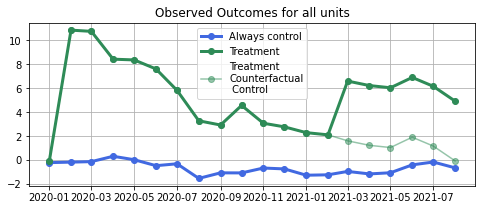

In [30]:
at_gt = 5
df = dgp.synth_panel(seed_number = 8751, 
                time_units = 20, 
                x_units = 50, 
                K_dim = 20,
                at = at_gt )

# display( df[[r for r in df.columns if 'treatment' in r and 'GT' not in r]].describe() )
# display('Test for overlap in treatment')
# display(pd.crosstab(df['treatment'], df['treatmentxpost']))
# print('Covariate Balance Plot')
# x_list = [p for p in df.columns if p[0]=='x']
# display(  df.groupby('treatment')[x_list].mean()  )

print('Plot stuff')
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))

ax.plot(df.loc[(df['treatment']==0)].groupby('T')['Y'].mean() , 
           '-o', color='royalblue', 
        linewidth=3, label='Always control')
ax.plot(df.loc[(df['treatment']==1) ].groupby('T')['Y'].mean() , 
           '-o', color='seagreen', 
        linewidth=3, label='Treatment')

ax.plot(df.loc[(df['treatment']==1) ].groupby('T')['Y_control'].mean() , 
           '-o', color='seagreen', alpha=0.50,
        label='Treatment\nCounterfactual\n Control')

ax.set_title('Observed Outcomes for all units')
ax.grid()
ax.legend()



In [31]:
## Clean data
di_dict = dgp.clean_and_input_data(df, 'treatment', 'post')

In [60]:
# ## Run DI Model
# ## Figure out the alpha and lambda values
# w=alpha_lambda.get_alpha_lambda(di_dict['C_pre'])
# alpha_lambda_to_use = alpha_lambda.alpha_lambda_transform(w.x)
# ## Take the alpha and lambda values, and estimate mu and omega
# di_est = di.predict_mu_omega(di_dict['T_pre'], di_dict['C_pre'], alpha_lambda_to_use, [10,4])
# # di_est = di.estimate_mu_omega(di_dict['T_pre'], di_dict['C_pre'], alpha_lambda_to_use)
# di_output = di.sc_style_results(di_dict['T_pre'], di_dict['T_pst'],
#                     di_dict['C_pre'], di_dict['C_pst'],
#                         di_est['mu'],di_est['omega'])
        


How to run the synthetic control models using this package:

```
di_dict = dgp.clean_and_input_data(df, 'treatment', 'post')

## Doudchenko/Imbens Model:
w=alpha_lambda.get_alpha_lambda(di_dict['C_pre'])
alpha_lambda_to_use = alpha_lambda.alpha_lambda_transform(w.x)
di_est = di.predict_mu_omega(di_dict['T_pre'], di_dict['C_pre'], alpha_lambda_to_use, [10,4])
di_output = di.sc_style_results(di_dict['T_pre'], di_dict['T_pst'],
                    di_dict['C_pre'], di_dict['C_pst'],
                        di_est['mu'],di_est['omega'])
pv_output = conformal_inf.pvalue_for_sc_output(sc_model_output=di_output,
                             di_dict=di_dict,
                              q=1,
                              number_permutations=500)
## Constrained Lasso Model:
ak7 = cl.predict_mu_omega(di_dict['T_pre'], di_dict['C_pre'], [10,4])
cl_output = di.sc_style_results(di_dict['T_pre'], di_dict['T_pst'],
                    di_dict['C_pre'], di_dict['C_pst'],
                    ak7['mu'], np.array(ak7['omega']))
pv_output = conformal_inf.pvalue_for_sc_output(sc_model_output=cl_output,
                             di_dict=di_dict,
                              q=1,
                              number_permutations=500)
                              
## Abadie-Diamond-Hainmueller:
ao3 = adh.predict_omega(di_dict['T_pre'], di_dict['C_pre'], [10,4])
adh_output = di.sc_style_results(di_dict['T_pre'], di_dict['T_pst'],
                    di_dict['C_pre'], di_dict['C_pst'],
                    np.zeros(di_dict['T_pst'].shape[1]), np.array(ao3['omega']))
pv_output = conformal_inf.pvalue_for_sc_output(sc_model_output=adh_output,
                             di_dict=di_dict,
                              q=1,
                              number_permutations=500)

```


In [61]:

## Run DI Model
## Figure out the alpha and lambda values
w=alpha_lambda.get_alpha_lambda(di_dict['C_pre'])
alpha_lambda_to_use = alpha_lambda.alpha_lambda_transform(w.x)
## Take the alpha and lambda values, and estimate mu and omega
di_est = di.predict_mu_omega(di_dict['T_pre'], di_dict['C_pre'], alpha_lambda_to_use, [10,4])
# di_est = di.estimate_mu_omega(di_dict['T_pre'], di_dict['C_pre'], alpha_lambda_to_use)
di_output = di.sc_style_results(di_dict['T_pre'], di_dict['T_pst'],
                    di_dict['C_pre'], di_dict['C_pst'],
                        di_est['mu'],di_est['omega'])

pv_output = conformal_inf.pvalue_for_sc_output(sc_model_output=di_output,
                             di_dict=di_dict,
                              q=1,
                              number_permutations=500)
print('DI PVALUES:')
for l in pv_output.keys():
    print('{1:5.3f}  : {0} '.format(l, pv_output[l]['pvalue']))
    
    
## Run CL Model
ak7 = cl.predict_mu_omega(di_dict['T_pre'], di_dict['C_pre'], [10,4])
cl_output = di.sc_style_results(di_dict['T_pre'], di_dict['T_pst'],
                    di_dict['C_pre'], di_dict['C_pst'],
                    ak7['mu'], np.array(ak7['omega']))
pv_output = conformal_inf.pvalue_for_sc_output(sc_model_output=cl_output,
                             di_dict=di_dict,
                              q=1,
                              number_permutations=500)
print('CL PVALUES:')
for l in pv_output.keys():
    print('{1:5.3f}  : {0} '.format(l, pv_output[l]['pvalue']))
    
    
## Run ADH Model
ao3 = adh.predict_omega(di_dict['T_pre'], di_dict['C_pre'], [10,4])
adh_output = di.sc_style_results(di_dict['T_pre'], di_dict['T_pst'],
                    di_dict['C_pre'], di_dict['C_pst'],
                    np.zeros(di_dict['T_pst'].shape[1]), np.array(ao3['omega']))
pv_output = conformal_inf.pvalue_for_sc_output(sc_model_output=adh_output,
                             di_dict=di_dict,
                              q=1,
                              number_permutations=500)
print('ADH PVALUES:')
for l in pv_output.keys():
    print('{1:5.3f}  : {0} '.format(l, pv_output[l]['pvalue']))


DI PVALUES:
0.000  : unit13_est 
0.032  : unit3_est 
0.000  : unit39_est 
0.000  : unit40_est 
0.000  : unit6_est 
CL PVALUES:
0.000  : unit13_est 
0.024  : unit3_est 
0.000  : unit39_est 
0.000  : unit40_est 
0.000  : unit6_est 
ADH PVALUES:
0.000  : unit13_est 
0.192  : unit3_est 
0.000  : unit39_est 
0.000  : unit40_est 
0.000  : unit6_est 


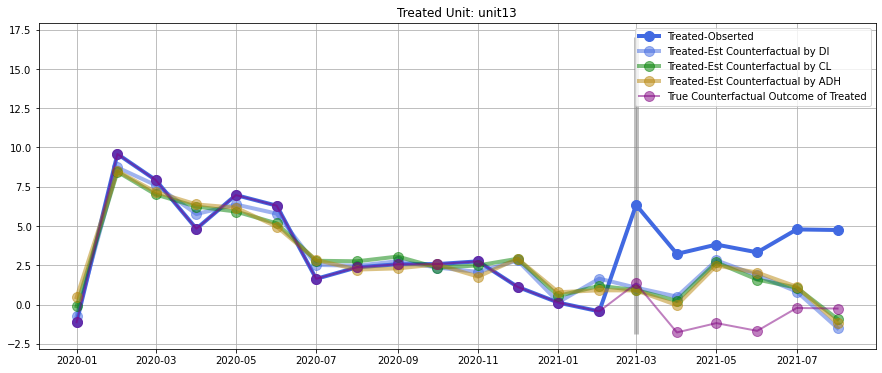

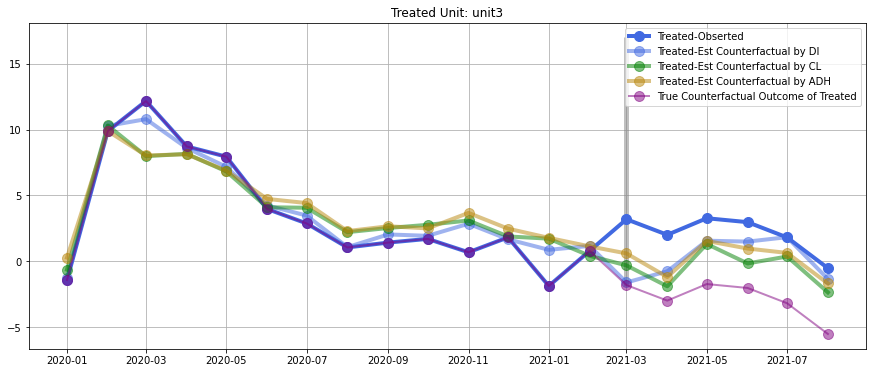

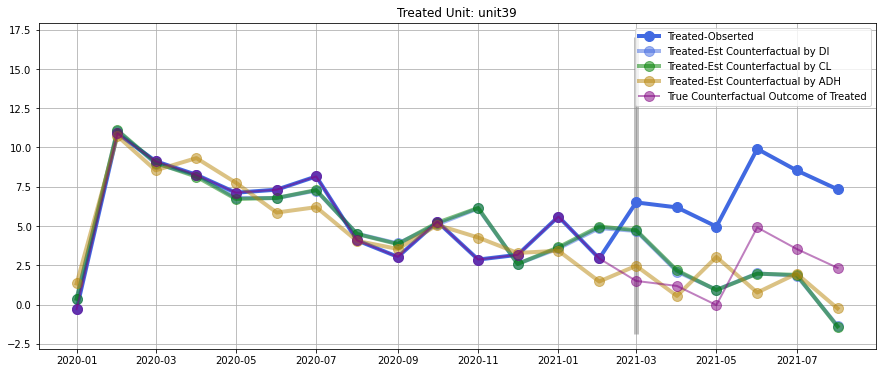

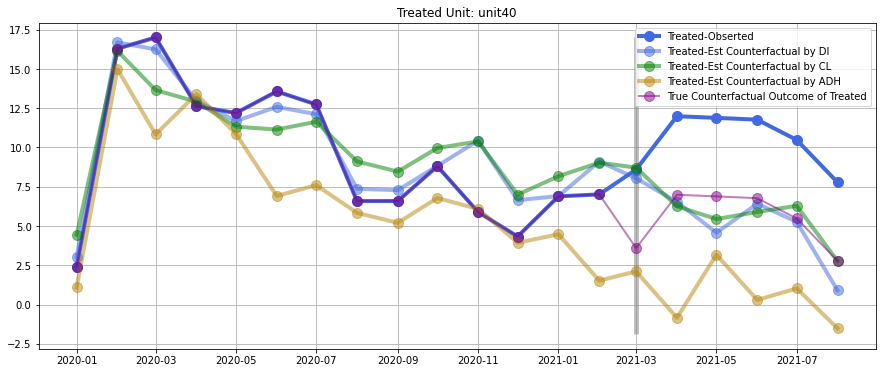

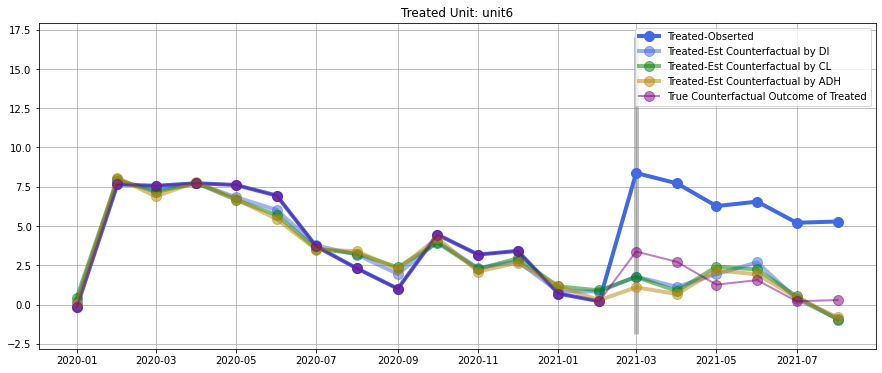

In [62]:


for r in [j for j in di_output['predict_est'].columns if '_est' not in j]:
    fig,ax=plt.subplots(ncols=1,nrows=1, figsize=(15,6))
    ax.plot(di_output['predict_est'].index, di_output['predict_est'][r], '-o', label='Treated-Obserted', 
           color='royalblue', alpha=1.0, linewidth=4, ms=10)
    
    ax.plot(di_output['predict_est'].index, di_output['predict_est'][r+'_est'], '-o', label='Treated-Est Counterfactual by DI',
           color='royalblue', alpha=0.5, linewidth=4, ms=10)
    
    ax.plot(cl_output['predict_est'].index, cl_output['predict_est'][r+'_est'], '-o', label='Treated-Est Counterfactual by CL',
           color='green', alpha=0.5, linewidth=4, ms=10)
    ax.plot(adh_output['predict_est'].index, adh_output['predict_est'][r+'_est'], '-o', label='Treated-Est Counterfactual by ADH',
           color='darkgoldenrod', alpha=0.5, linewidth=4, ms=10)

    
    ax.vlines(df.loc[(df['post']==1)]['T'].min(), 
              di_output['predict_est'].min().min(),
              di_output['predict_est'].max().max(),              
              linewidth=5, color='grey',alpha=0.5)
    
    ax.plot(di_output['predict_est'].index, df.loc[df['unitid']==r]['Y_control'],
            '-o',label='True Counterfactual Outcome of Treated',
           color='purple', alpha=0.5, linewidth=2, ms=10)                
#     ax.plot(di_output['predict_est'].index, pd.concat([di_dict['C_pre'],di_dict['C_pst']],axis=0).mean(axis=1),
#                '-o',label='Unweighted Avg of Controls',
#                color='coral', linewidth=4, ms=10)

    ax.grid()
    ax.set_title('Treated Unit: {0}'.format(r))
    ax.legend()
    plt.show()

In [11]:

print('Ground Truth ATET: {0:5.3f}'.format(at_gt))
print('  DI Est |bias| : {0:5.3f}'.format(evalmetric.abs_v( di_output['atet'],at_gt))  )
print('  DI Est |bias|%: {0:5.3f}'.format(evalmetric.abs_p( di_output['atet'],at_gt))  )
print('  DI Est |bias|-R2: {0:5.3f}'.format(evalmetric.r2( di_output['atet'],at_gt))  )
print('  CL Est |bias| : {0:5.3f}'.format(evalmetric.abs_v( cl_output['atet'],at_gt))  )
print('  CL Est |bias|%: {0:5.3f}'.format(evalmetric.abs_p( cl_output['atet'],at_gt))  )
print('  CL Est |bias|-R2: {0:5.3f}'.format(evalmetric.r2( cl_output['atet'],at_gt))  )
print(' ADH Est |bias| : {0:5.3f}'.format(evalmetric.abs_v(adh_output['atet'],at_gt))  )
print(' ADH Est |bias|%: {0:5.3f}'.format(evalmetric.abs_p(adh_output['atet'],at_gt))  )
print(' ADH Est |bias|-R2: {0:5.3f}'.format(evalmetric.r2( adh_output['atet'],at_gt))  )
print('   Distribution of Bias across units:')
display( pd.concat( [di_output['atet'].mean() , 
            cl_output['atet'].mean(), 
            adh_output['atet'].mean()  ], axis=1).rename(columns={0:'di',
                                                                  1:'cl',
                                                                  2:'adh'})-at_gt  )  

Ground Truth ATET: 5.000
  DI Est |bias| : 2.005
  DI Est |bias|%: 0.401
  DI Est |bias|-R2: 0.002
  CL Est |bias| : 1.836
  CL Est |bias|%: 0.367
  CL Est |bias|-R2: 0.003
 ADH Est |bias| : 2.604
 ADH Est |bias|%: 0.521
 ADH Est |bias|-R2: 0.369
   Distribution of Bias across units:


/Users/hsujulia/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/hsujulia/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,di,cl,adh
unit13,-1.557577,-1.557291,-1.514635
unit3,-3.072872,-2.367238,-3.022654
unit39,0.541172,0.523865,0.815652
unit40,0.128347,-0.475690,4.710088
unit6,0.403527,0.431785,0.656091


### Simulation study of bias
When we compare all three models - DI, CL, and ADH - we want to look at potential drivers of varying performance.


In [12]:
class evalmetric:
    ## Variation in observed outcomes
    def pst_variation(data):
        ## Estimate the variation in the observed outcome of treated units, post treatment
        obs_var = data.loc[(data['treatment']==1) & (data['post']==1)]['Y'].var()
        ## Estimate the variation in the counterfactual outcome of treated units, post treatment
        cnt_var = data.loc[(data['treatment']==1) & (data['post']==1)]['Y_control'].var()
        return obs_var, cnt_var
    def holdout(results):
        return results['mse_holdout'].mean()
    
    def abs_v(x,gt):
        return np.mean( [ np.abs(i-gt) for i in x.values] )
    def abs_p(x,gt):
        return np.mean( [ np.abs(i-gt)/gt for i in x.values] )        
    
    def r2(x,gt):
        x_list = [i for i in x]
        return (   np.corrcoef(x,np.ones(len(x_list))*gt)[0,1]   )**2
            

In [23]:
data_settings = {'at':10,
                'time_units':20,
                'x_units':50,
                'K_dim':20}
treatment_window = [10,4]
sim_results_df = pd.DataFrame()
for s in range(1000):
    s_df = dgp.synth_panel(seed_number = np.random.randint(0,5000),
                          at=data_settings['at'],
                                 time_units=data_settings['time_units'],
                                 x_units=data_settings['x_units'],
                                 K_dim=data_settings['K_dim'])


    ## Clean data
    di_dict = dgp.clean_and_input_data(s_df, 'treatment', 'post')
    ## Run DI Model
    ## Figure out the alpha and lambda values
    w=alpha_lambda.get_alpha_lambda(di_dict['C_pre'])
    alpha_lambda_to_use = alpha_lambda.alpha_lambda_transform(w.x)
    ## Take the alpha and lambda values, and estimate mu and omega
    di_est = di.predict_mu_omega(di_dict['T_pre'], di_dict['C_pre'], alpha_lambda_to_use, [10,4])
    # di_est = di.estimate_mu_omega(di_dict['T_pre'], di_dict['C_pre'], alpha_lambda_to_use)
    di_output = di.sc_style_results(di_dict['T_pre'], di_dict['T_pst'],
                        di_dict['C_pre'], di_dict['C_pst'],
                            di_est['mu'],di_est['omega'])


    ## Run CL Model
    ak7 = cl.predict_mu_omega(di_dict['T_pre'], di_dict['C_pre'], [10,4])
    cl_output = di.sc_style_results(di_dict['T_pre'], di_dict['T_pst'],
                        di_dict['C_pre'], di_dict['C_pst'],
                        ak7['mu'], np.array(ak7['omega']))

    ## Run ADH Model
    ao3 = adh.predict_omega(di_dict['T_pre'], di_dict['C_pre'], [10,4])
    adh_output = di.sc_style_results(di_dict['T_pre'], di_dict['T_pst'],
                        di_dict['C_pre'], di_dict['C_pst'],
                        np.zeros(di_dict['T_pst'].shape[1]), np.array(ao3['omega']))



    sim_row = pd.DataFrame(index=[s], data={'DI_holdout_mse': evalmetric.holdout(di_est),
                                            'CL_holdout_mse': evalmetric.holdout(ak7),
                                            'ADH_holdout_mse': evalmetric.holdout(ao3),
                                            'Y_obs_post_var':evalmetric.pst_variation(s_df)[0],
                                            'DI_MAE': evalmetric.abs_v(di_output['atet'],data_settings['at']),
                                            'CL_MAE': evalmetric.abs_v(cl_output['atet'],data_settings['at']),
                                            'ADH_MAE': evalmetric.abs_v(adh_output['atet'],data_settings['at']),       
                                            'DI_MAPE': evalmetric.abs_p(di_output['atet'],data_settings['at']),
                                            'CL_MAPE': evalmetric.abs_p(cl_output['atet'],data_settings['at']),
                                            'ADH_MAPE': evalmetric.abs_p(adh_output['atet'],data_settings['at']),
                                           })
    sim_results_df = pd.concat([sim_results_df,sim_row])


In [24]:
sim_results_df.describe().T

,count,mean,std,min,25%,50%,75%,max
DI_holdout_mse,1000.0,14.925286,8.406715,1.193532,8.781835,13.447204,19.524615,66.813004
CL_holdout_mse,1000.0,20.636163,15.274242,1.132500,10.422973,16.715218,26.024678,119.572889
ADH_holdout_mse,1000.0,3.739951,3.791119,0.302740,1.449778,2.370335,4.492068,33.115900
Y_obs_post_var,1000.0,5.197646,1.838014,1.643698,3.837522,4.926215,6.258165,14.353282
Y_cnt_post_var,1000.0,5.197646,1.838014,1.643698,3.837522,4.926215,6.258165,14.353282
DI_MAE,1000.0,1.804343,0.398520,1.039778,1.533637,1.750404,1.984131,4.119430
CL_MAE,1000.0,1.900183,0.438724,0.975728,1.602240,1.815973,2.108168,4.737867
ADH_MAE,1000.0,1.910431,0.389093,1.035991,1.650768,1.841075,2.110615,3.913032
DI_MAPE,1000.0,0.180434,0.039852,0.103978,0.153364,0.175040,0.198413,0.411943
CL_MAPE,1000.0,0.190018,0.043872,0.097573,0.160224,0.181597,0.210817,0.473787


In [49]:
display( sim_results_df[[x for x in sim_results_df.columns if '_MAPE' in x]].corr() )


,DI_MAPE,CL_MAPE,ADH_MAPE
DI_MAPE,1.000000,0.882923,0.273054
CL_MAPE,0.882923,1.000000,0.254435
ADH_MAPE,0.273054,0.254435,1.000000


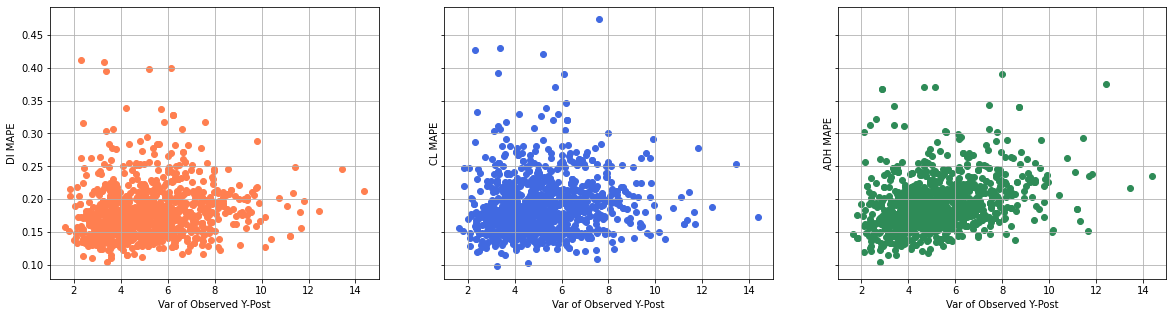

In [31]:
fig,ax = plt.subplots(ncols=3, nrows=1, figsize=(20,5), sharex=True, sharey=True)
ax[0].scatter(sim_results_df['Y_obs_post_var'],
             sim_results_df['DI_MAPE'],
             color='coral')
ax[0].set_ylabel('DI MAPE')
ax[0].set_xlabel('Var of Observed Y-Post')
ax[0].grid()

ax[1].scatter(sim_results_df['Y_obs_post_var'],
             sim_results_df['CL_MAPE'],
             color='royalblue')
ax[1].set_ylabel('CL MAPE')
ax[1].set_xlabel('Var of Observed Y-Post')
ax[1].grid()

ax[2].scatter(sim_results_df['Y_obs_post_var'],
             sim_results_df['ADH_MAPE'],
             color='seagreen')
ax[2].set_ylabel('ADH MAPE')
ax[2].set_xlabel('Var of Observed Y-Post')
ax[2].grid()

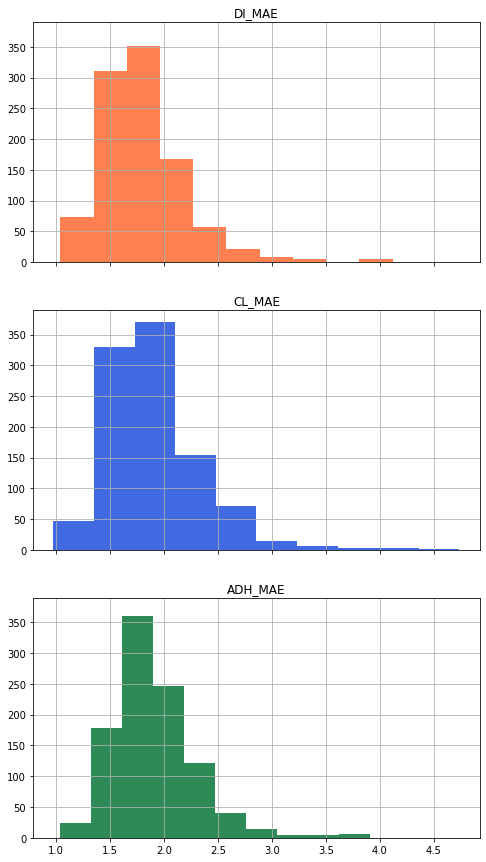

In [38]:
fig,ax = plt.subplots(ncols=1, nrows=3, figsize=(8,15), sharex=True, sharey=True)
ax[0].hist(sim_results_df['DI_MAE'],
             color='coral')
ax[0].set_title('DI_MAE')
ax[0].grid()

ax[1].hist(sim_results_df['CL_MAE'],
             color='royalblue')
ax[1].set_title('CL_MAE')
ax[1].grid()

ax[2].hist(sim_results_df['ADH_MAE'],
             color='seagreen')
ax[2].set_title('ADH_MAE')
ax[2].grid()